In [1]:
import pandas as pd
import os
import numpy as np
from dateutil.relativedelta import relativedelta

## Database Connection String and Data Read

In [2]:
# Load data (to be replaced by AWS connection string)
shelter_data_to_load = "Animal_Shelter_Intake_and_Outcome.csv"
shelter_data_df = pd.read_csv(shelter_data_to_load)
shelter_data_df.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,NaN,CAT,SIAMESE,BLACK/BLACK,Female,KITTN,NaN,K22-042204,CS05,A412797,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
1,NaN,CAT,DOMESTIC SH,GRAY/WHITE,Male,KITTN,06/24/2022,K22-042194,CA03,A412786,...,PHONE,NaN,NaN,UNKNOWN,NaN,COUNTY,NaN,NaN,NaN,1
2,NaN,CAT,SIAMESE,GRAY/BLACK,Female,KITTN,NaN,K22-042201,CS05,A412794,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
3,NaN,CAT,SIAMESE,GRAY/BLACK,Female,KITTN,NaN,K22-042202,CS05,A412795,...,FIELD,TRANSFER,FORGOTTEN,TREATABLE/REHAB,TREATABLE/REHAB,SANTA ROSA,SANTA ROSA,95403.0,"95403(38.486997, -122.749134)",1
4,NaN,CAT,DOMESTIC SH,BLACK,Female,SMALL,12/30/2020,K22-041790,SMM,A412222,...,FIELD,TRANSFER,WE CARE,UNKNOWN,HEALTHY,COUNTY,OUT OF COUNTY,94574.0,"94574(38.525993, -122.432854)",1


## Machine Learning Data Preprocessing

In [3]:
# Data analysis
col_det_df = shelter_data_df
columns_details_df = pd.DataFrame()
count = col_det_df.count()
null = col_det_df.isnull().sum()
unique = col_det_df.nunique()
dtype = col_det_df.dtypes
columns_details_df['count'] = count
columns_details_df['null'] = null
columns_details_df['unique'] = unique
columns_details_df['dtype'] = dtype
columns_details_df

,count,null,unique,dtype
Name,17291,6179,6320,object
Type,23470,0,3,object
Breed,23470,0,1005,object
Color,23470,0,332,object
Sex,23470,0,5,object
Size,23437,33,7,object
Date Of Birth,17618,5852,5442,object
Impound Number,23470,0,23470,object
Kennel Number,23462,8,161,object
Animal ID,23470,0,21200,object


In [4]:
# Animal type analysis
type_count = shelter_data_df.groupby(["Type"]).count()
type_count

,Name,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
Type,,,,,,,,,,,,,,,,,,,,,
CAT,4822,8330,8330,8330,8328,6066,8330,8327,8330,8330,...,8330,8268,8177,8330,8150,8330,6797,6797,6797,8330
DOG,11874,13242,13242,13242,13211,10958,13242,13237,13242,13242,...,13242,13140,13029,13242,13035,13242,11994,11934,11934,13242
OTHER,595,1898,1898,1898,1898,594,1898,1898,1898,1898,...,1898,1872,1767,1898,1758,1898,1384,1371,1371,1898


In [5]:
# Data cleaning pre-processing for ML
# Filter columns
filtered_df = shelter_data_df[['Type','Sex','Size','Date Of Birth','Intake Date',
                               'Days in Shelter','Intake Type','Intake Subtype',
                               'Outcome Type','Intake Condition','Intake Jurisdiction']]
# Filter only 'CAT' and 'DOG'
# filtered_df = filtered_df[filtered_df['Type'] != "OTHER"]
filtered_df = filtered_df[filtered_df['Type'] == "CAT"]
# filtered_df = filtered_df[filtered_df['Type'] == "DOG"]
# Change column name
filtered_df = filtered_df.rename(columns={'Type': 'Animal Type'})
# Group ML target classes
# filtered_df['Outcome Type'].replace({'ADOPTION':'ADOPTION RETURN','RETURN TO OWNER':'ADOPTION RETURN'},inplace=True)
# Group other classes
filtered_df['Sex'].replace({'Spayed':'Spayed or Neutered','Neutered':'Spayed or Neutered'},inplace=True)
filtered_df['Intake Subtype'].replace({'BORN_HERE':'OTHER','COMM CAT':'OTHER','FIELD':'FIELD',
                                       'FIELD_OS':'FIELD','FIELD_RETURN TO OWNER':'FIELD','FLD_ABAND':'FIELD',
                                       'FLD_ARREST':'FIELD','FLD_CORONR':'FIELD','FLD_CRUEL':'FIELD',
                                       'FLD_EMERGE':'FIELD','FLD_EVICT':'FIELD','FLD_HOSPTL':'FIELD',
                                       'FLD_INVEST':'FIELD','FLD_LIVSTK':'FIELD','FLD_OWNED':'FIELD',
                                       'FLD_STRAY':'FIELD','MUN_SHELT':'OTHER','OVER THE COUNTER':'OVER THE COUNTER',
                                       'OVER THE COUNTER_ARREST':'OVER THE COUNTER','OVER THE COUNTER_CORONR':'OVER THE COUNTER','OVER THE COUNTER_EVICT':'OVER THE COUNTER',
                                       'OVER THE COUNTER_OS':'OVER THE COUNTER','OVER THE COUNTER_OWNED':'OVER THE COUNTER','OVER THE COUNTER_RETURN TO OWNER':'OVER THE COUNTER',
                                       'OVER THE COUNTER_STRAY':'OVER THE COUNTER','PHONE':'OTHER','PRIV_SHELT':'OTHER',
                                       'RESCUE_GRP':'OTHER','VET_HOSP':'OTHER'
                                      },inplace=True)
# Drop NaN
filtered_df = filtered_df.dropna()
# Change dates dtype
filtered_df[['Date Of Birth','Intake Date']] = filtered_df[['Date Of Birth','Intake Date']].apply(pd.to_datetime)
# Calculate 'Age at intake time' and drop
filtered_df['Age at Intake'] = filtered_df['Intake Date'] - filtered_df['Date Of Birth']
filtered_df['Age at Intake'] = filtered_df['Age at Intake']/np.timedelta64(1, 'Y')
# Remove negative values in 'Age at intake time'
filtered_df = filtered_df[filtered_df['Age at Intake'] > 0]
# Change 'Days in shelter' dtype and format
filtered_df['Days in Shelter'] = filtered_df['Days in Shelter'].str.replace(',', '').astype(float)
# Drop days in shelter = 0
filtered_df = filtered_df[filtered_df['Days in Shelter'] > 0]
filtered_df.head()

,Animal Type,Sex,Size,Date Of Birth,Intake Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Intake Condition,Intake Jurisdiction,Age at Intake
4,CAT,Female,SMALL,2020-12-30,2022-06-30,41.0,STRAY,FIELD,TRANSFER,UNKNOWN,COUNTY,1.497635
6,CAT,Male,SMALL,2015-08-03,2022-08-03,6.0,STRAY,OVER THE COUNTER,TRANSFER,UNKNOWN,SANTA ROSA,7.000828
59,CAT,Male,SMALL,2021-08-09,2022-08-09,3.0,STRAY,FIELD,EUTHANIZE,UNKNOWN,COUNTY,0.999336
72,CAT,Spayed or Neutered,SMALL,2002-08-09,2022-08-09,3.0,OWNER SURRENDER,FIELD,EUTHANIZE,UNKNOWN,SANTA ROSA,20.000411
92,CAT,Spayed or Neutered,SMALL,2022-05-06,2022-07-06,38.0,CONFISCATE,FIELD,ADOPTION,HEALTHY,SANTA ROSA,0.167012


In [6]:
# Drop dates columns
filtered_df = filtered_df.drop('Date Of Birth', axis=1)
filtered_df = filtered_df.drop('Intake Date', axis=1)
filtered_df.head()

,Animal Type,Sex,Size,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Intake Condition,Intake Jurisdiction,Age at Intake
4,CAT,Female,SMALL,41.0,STRAY,FIELD,TRANSFER,UNKNOWN,COUNTY,1.497635
6,CAT,Male,SMALL,6.0,STRAY,OVER THE COUNTER,TRANSFER,UNKNOWN,SANTA ROSA,7.000828
59,CAT,Male,SMALL,3.0,STRAY,FIELD,EUTHANIZE,UNKNOWN,COUNTY,0.999336
72,CAT,Spayed or Neutered,SMALL,3.0,OWNER SURRENDER,FIELD,EUTHANIZE,UNKNOWN,SANTA ROSA,20.000411
92,CAT,Spayed or Neutered,SMALL,38.0,CONFISCATE,FIELD,ADOPTION,HEALTHY,SANTA ROSA,0.167012


In [7]:
# Data analysis
col_det_df = filtered_df
cleaned_columns_details_df = pd.DataFrame()
count = col_det_df.count()
null = col_det_df.isnull().sum()
unique = col_det_df.nunique()
dtype = col_det_df.dtypes
cleaned_columns_details_df['count'] = count
cleaned_columns_details_df['null'] = null
cleaned_columns_details_df['unique'] = unique
cleaned_columns_details_df['dtype'] = dtype
cleaned_columns_details_df

,count,null,unique,dtype
Animal Type,5327,0,1,object
Sex,5327,0,4,object
Size,5327,0,6,object
Days in Shelter,5327,0,138,float64
Intake Type,5327,0,6,object
Intake Subtype,5327,0,3,object
Outcome Type,5327,0,8,object
Intake Condition,5327,0,5,object
Intake Jurisdiction,5327,0,12,object
Age at Intake,5327,0,1005,float64


In [8]:
# Generate a categorical variable list
filtered_df_cat = filtered_df.dtypes[filtered_df.dtypes == "object"].index.tolist()
filtered_df_cat

['Animal Type',
 'Sex',
 'Size',
 'Intake Type',
 'Intake Subtype',
 'Outcome Type',
 'Intake Condition',
 'Intake Jurisdiction']

In [9]:
# Check the number of unique values in each column
filtered_df[filtered_df_cat].nunique()

Animal Type             1
Sex                     4
Size                    6
Intake Type             6
Intake Subtype          3
Outcome Type            8
Intake Condition        5
Intake Jurisdiction    12
dtype: int64

In [10]:
from sklearn.preprocessing import OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(filtered_df[filtered_df_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(filtered_df_cat)
encode_df.head()

,Animal Type_CAT,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*HEALDSBURG,Intake Jurisdiction_*PETALUMA,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
# Merge one-hot encoded features and drop the originals
filtered_df = filtered_df.merge(encode_df,left_index=True, right_index=True)
filtered_encoded_df = filtered_df.drop(filtered_df_cat,1)
filtered_encoded_df.head()

C:\Users\fernanm\Anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Days in Shelter,Age at Intake,Animal Type_CAT,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,Size_MED,...,Intake Jurisdiction_*HEALDSBURG,Intake Jurisdiction_*PETALUMA,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN
4,41.0,1.497635,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,6.0,7.000828,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
59,3.0,0.999336,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
72,3.0,20.000411,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
92,38.0,0.167012,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
filtered_encoded_df.columns

Index(['Days in Shelter', 'Age at Intake', 'Animal Type_CAT', 'Sex_Female',
       'Sex_Male', 'Sex_Spayed or Neutered', 'Sex_Unknown', 'Size_KITTN',
       'Size_LARGE', 'Size_MED', 'Size_SMALL', 'Size_TOY', 'Size_X-LRG',
       'Intake Type_ADOPTION RETURN', 'Intake Type_CONFISCATE',
       'Intake Type_OWNER SURRENDER', 'Intake Type_QUARANTINE',
       'Intake Type_STRAY', 'Intake Type_TRANSFER', 'Intake Subtype_FIELD',
       'Intake Subtype_OTHER', 'Intake Subtype_OVER THE COUNTER',
       'Outcome Type_ADOPTION', 'Outcome Type_DIED', 'Outcome Type_DISPOSAL',
       'Outcome Type_ESCAPED/STOLEN', 'Outcome Type_EUTHANIZE',
       'Outcome Type_RETURN TO OWNER', 'Outcome Type_RTOS',
       'Outcome Type_TRANSFER', 'Intake Condition_HEALTHY',
       'Intake Condition_TREATABLE/MANAGEABLE',
       'Intake Condition_TREATABLE/REHAB', 'Intake Condition_UNKNOWN',
       'Intake Condition_UNTREATABLE', 'Intake Jurisdiction_*CLOVERDALE',
       'Intake Jurisdiction_*COTATI', 'Intake Jurisd

In [13]:
# Drop other outcome types
# filtered_encoded_df = filtered_encoded_df.drop(['Outcome Type_DIED','Outcome Type_DISPOSAL',
#                                                 'Outcome Type_ESCAPED/STOLEN','Outcome Type_EUTHANIZE',
#                                                 'Outcome Type_RTOS','Outcome Type_TRANSFER'], axis=1)

filtered_encoded_df = filtered_encoded_df.drop(['Outcome Type_DIED','Outcome Type_DISPOSAL','Outcome Type_RETURN TO OWNER',
                                                'Outcome Type_ESCAPED/STOLEN','Outcome Type_EUTHANIZE',
                                                'Outcome Type_RTOS','Outcome Type_TRANSFER'], axis=1)

In [37]:
# Copy columns to be scaled
scale_df = filtered_encoded_df[['Days in Shelter', 'Age at Intake']].copy()
scale_df.head()

,Days in Shelter,Age at Intake
4,41.0,1.497635
6,6.0,7.000828
59,3.0,0.999336
72,3.0,20.000411
92,38.0,0.167012


In [34]:
# Describe columns to be scaled
scale_df.describe()

,Days in Shelter,Age at Intake
count,1212.000000,1212.000000
mean,23.391089,2.253151
std,23.340240,3.757806
min,1.000000,0.002738
25%,7.000000,0.167012
50%,16.000000,0.320335
75%,33.000000,2.186219
max,258.000000,20.000411


In [15]:
# Create the Scaler instance
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# scaler = RobustScaler()
scaler = StandardScaler()

In [16]:
# Fit the Scaler
scaler.fit(scale_df)

StandardScaler()

In [17]:
# Scale the data
scaled_data = scaler.transform(scale_df)

In [18]:
# Create a DataFrame with the scaled data
transformed_scaled_data = pd.DataFrame(scaled_data, index=scale_df.index, columns=scale_df.columns)
transformed_scaled_data.head()

,Days in Shelter,Age at Intake
4,0.754756,-0.201135
6,-0.745419,1.263939
59,-0.874006,-0.333794
72,-0.874006,4.724722
92,0.626169,-0.555377


In [19]:
filtered_encoded_scaled_df = filtered_encoded_df.merge(transformed_scaled_data, how = 'outer', 
                                                left_index = True, right_index = True)
filtered_encoded_scaled_df.head()

,Days in Shelter_x,Age at Intake_x,Animal Type_CAT,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,Size_MED,...,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
4,41.0,1.497635,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.754756,-0.201135
6,6.0,7.000828,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.745419,1.263939
59,3.0,0.999336,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874006,-0.333794
72,3.0,20.000411,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874006,4.724722
92,38.0,0.167012,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.626169,-0.555377


In [20]:
filtered_encoded_scaled_df = filtered_encoded_scaled_df.drop(['Days in Shelter_x','Age at Intake_x'], axis=1)
filtered_encoded_scaled_df.head()

,Animal Type_CAT,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.754756,-0.201135
6,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.745419,1.263939
59,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874006,-0.333794
72,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874006,4.724722
92,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.626169,-0.555377


In [21]:
# Export CSV or create testing df
# filtered_encoded_scaled_df.to_csv('sonoma_shelter_ML_test.csv',index=False)
df = filtered_encoded_scaled_df.copy()
df = df.reset_index(drop=True)
df.head(5)

,Animal Type_CAT,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.754756,-0.201135
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.745419,1.263939
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874006,-0.333794
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.874006,4.724722
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.626169,-0.555377


## PyCaret

In [22]:
import pycaret
from pycaret.regression import *

In [23]:
data = df.sample(frac=0.9, random_state=786).reset_index(drop=True)
data_unseen = df.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1091, 40)
Unseen Data For Predictions: (121, 40)


In [24]:
# exp_reg101 = setup(data = df,
#                    target = 'Outcome Type_ADOPTION RETURN',
#                    ignore_features = ['listing image','listing url','full address','zipcode']) 

# exp_reg101 = setup(data = df,
#                    target = 'Outcome Type_ADOPTION RETURN')

exp_reg101 = setup(data = df,
                   target = 'Outcome Type_ADOPTION')

,Description,Value
0,session_id,6990
1,Target,Outcome Type_ADOPTION
2,Original Data,"(1212, 40)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,30
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(848, 39)"


In [25]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2395,0.1171,0.3419,0.4932,0.0000,0.1869,0.0280
br,Bayesian Ridge,0.2775,0.1240,0.3516,0.4640,0.0000,0.2006,0.0060
ridge,Ridge Regression,0.2768,0.1241,0.3518,0.4633,0.0000,0.1989,0.0060
rf,Random Forest Regressor,0.2275,0.1305,0.3603,0.4346,0.0000,0.1835,0.1890
ada,AdaBoost Regressor,0.3090,0.1351,0.3671,0.4148,0.0000,0.3018,0.0150
omp,Orthogonal Matching Pursuit,0.3037,0.1426,0.3767,0.3838,0.0000,0.2210,0.0070
et,Extra Trees Regressor,0.2222,0.1626,0.4015,0.2957,0.0000,0.1811,0.1690
huber,Huber Regressor,0.2151,0.2027,0.4478,0.1279,0.0000,0.0208,0.0140
dt,Decision Tree Regressor,0.2230,0.2230,0.4698,0.0307,0.0000,0.1804,0.6510
lasso,Lasso Regression,0.4647,0.2325,0.4821,-0.0062,0.0000,0.3667,0.0060


In [26]:
model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2552,0.1231,0.3508,0.4322,-0.0000,0.2450
1,0.2230,0.1080,0.3286,0.4913,-0.0000,0.1675
2,0.2285,0.1121,0.3349,0.5328,-0.0000,0.1678
3,0.2216,0.1075,0.3278,0.5220,-0.0000,0.1822
4,0.2188,0.1091,0.3303,0.5352,-0.0000,0.1718
5,0.2394,0.1255,0.3542,0.4772,-0.0000,0.1306
6,0.2582,0.1162,0.3408,0.4914,-0.0000,0.2179
7,0.2611,0.1324,0.3638,0.4485,-0.0000,0.2053
8,0.2258,0.1070,0.3271,0.5464,-0.0000,0.1727


In [27]:
tuned_gbr = tune_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2799,0.1214,0.3484,0.4399,-0.0000,0.2582
1,0.2628,0.1090,0.3302,0.4866,-0.0000,0.2144
2,0.2660,0.1122,0.3350,0.5325,-0.0000,0.1936
3,0.2581,0.1098,0.3314,0.5114,-0.0000,0.2084
4,0.2565,0.1030,0.3209,0.5614,-0.0000,0.2062
5,0.2999,0.1488,0.3858,0.3798,-0.0000,0.1945
6,0.2756,0.1100,0.3316,0.5184,-0.0000,0.2172
7,0.2932,0.1347,0.3670,0.4388,-0.0000,0.2209
8,0.2729,0.1184,0.3441,0.4979,-0.0000,0.2097


In [28]:
# plot_model(tuned_gbr)

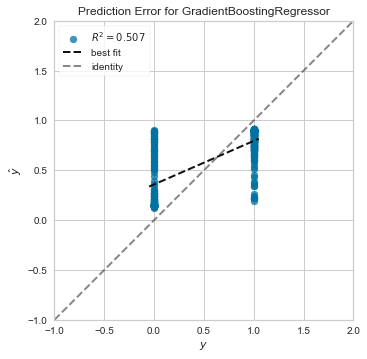

In [29]:
plot_model(tuned_gbr, plot = 'error')

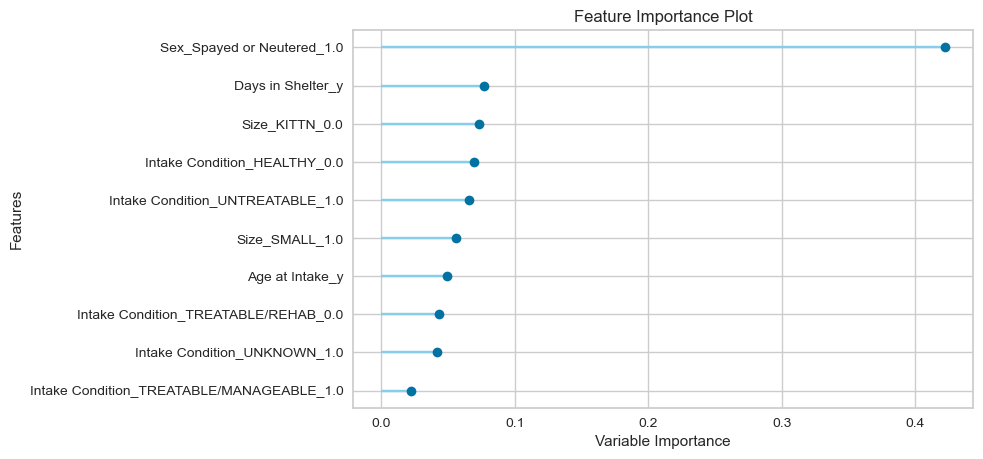

In [30]:
plot_model(tuned_gbr, plot='feature')

In [31]:
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [32]:
unseen_predictions = predict_model(tuned_gbr, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.2401,0.0875,0.2957,0.6346,0.2126,0.1955


,Animal Type_CAT,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y,Label
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.316798,-0.513830,0.141041
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.402522,-0.532781,0.141041
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.155036,-0.333794,0.845563
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.488247,-0.532781,0.141041
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.702557,-0.333794,0.799705


In [33]:
# unseen_predictions.to_csv('predictions.csv',index=False)
# unseen_predictions.to_csv('adoptions.csv',index=False)

## Gradient Boosting Regressor

#### Define features and Split the Data into Training and Testing

In [38]:
# Define features
X = df.copy()
# X = X.drop('Outcome Type_ADOPTION RETURN', axis=1)
X = X.drop('Outcome Type_ADOPTION', axis=1)
X.head()
# Create our target
# y = df['Outcome Type_ADOPTION RETURN']
y = df['Outcome Type_ADOPTION']

In [39]:
X.describe()

,Animal Type_CAT,Sex_Female,Sex_Male,Sex_Spayed or Neutered,Sex_Unknown,Size_KITTN,Size_LARGE,Size_MED,Size_SMALL,Size_TOY,...,Intake Jurisdiction_*ROHNERT PARK,Intake Jurisdiction_*SEBASTOPOL,Intake Jurisdiction_*SONOMA,Intake Jurisdiction_*WINDSOR,Intake Jurisdiction_COUNTY,Intake Jurisdiction_OUT OF COUNTY,Intake Jurisdiction_SANTA ROSA,Intake Jurisdiction_UNKNOWN,Days in Shelter_y,Age at Intake_y
count,1212.0,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.0,...,1212.000000,1212.000000,1212.0,1212.000000,1212.000000,1212.000000,1212.000000,1212.0,1.212000e+03,1.212000e+03
mean,1.0,0.072607,0.058581,0.842409,0.026403,0.501650,0.008251,0.014851,0.475248,0.0,...,0.004950,0.000825,0.0,0.069307,0.449670,0.012376,0.457096,0.0,2.357850e-16,3.980131e-17
std,0.0,0.259598,0.234935,0.364507,0.160396,0.500204,0.090496,0.121008,0.499593,0.0,...,0.070214,0.028724,0.0,0.254080,0.497666,0.110604,0.498361,0.0,1.000413e+00,1.000413e+00
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-9.597301e-01,-5.991107e-01
25%,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-7.025573e-01,-5.553772e-01
50%,1.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-3.167979e-01,-5.145592e-01
75%,1.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000,0.0,4.118585e-01,-1.781878e-02
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.005584e+01,4.724722e+00


In [40]:
# Check the balance of our target values
y.value_counts()

1.0    761
0.0    451
Name: Outcome Type_ADOPTION, dtype: int64

In [42]:
# Split the Data into Training and Testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
X_train.shape

(909, 39)

#### Run GBR

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
# Test model parameters and loop learning rates
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    regressor = GradientBoostingRegressor(n_estimators=100,
                                            learning_rate=learning_rate,
                                            max_features=5,
                                            max_depth=3,
                                            criterion = 'mse',
                                            random_state=0)
    # Fit the model
    regressor.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        regressor.score(
            X_train,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        regressor.score(
            X_test,
            y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.546
Accuracy score (validation): 0.536

Learning rate:  0.1
Accuracy score (training): 0.590
Accuracy score (validation): 0.561

Learning rate:  0.25
Accuracy score (training): 0.651
Accuracy score (validation): 0.537

Learning rate:  0.5
Accuracy score (training): 0.698
Accuracy score (validation): 0.520

Learning rate:  0.75
Accuracy score (training): 0.728
Accuracy score (validation): 0.523

Learning rate:  1
Accuracy score (training): 0.747
Accuracy score (validation): 0.414



In [64]:
# Choose parameters and create regessor
regressor_params = {'n_estimators': 100,
                    'learning_rate': 0.25,
                    'max_features': 5,
                    'max_depth': 3,
                    'criterion': 'mse',
                    'random_state': 0}

regressor = GradientBoostingRegressor(**regressor_params)
# Fit the model
regressor.fit(X_train, y_train)
# Make Prediction
predictions = regressor.predict(X_test)
# predictions

#### Evaluate model

In [54]:
# Print Coefficient of determination R2
print("Model Accuracy: %.3f" % regressor.score(X_test, y_test))
# Print the mean squared error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, regressor.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.537
The mean squared error (MSE) on test set: 0.1083


In [55]:
# Sort the features by their importance
features_imp_df = pd.DataFrame(sorted(zip(regressor.feature_importances_, X.columns), reverse=True))
features_imp_df.columns = ['%', 'Feature']
features_imp_df.head(10)

,%,Feature
0,0.258335,Sex_Spayed or Neutered
1,0.103381,Size_SMALL
2,0.101848,Intake Condition_UNTREATABLE
3,0.068859,Intake Condition_UNKNOWN
4,0.067421,Sex_Female
5,0.051468,Sex_Unknown
6,0.047619,Days in Shelter_y
7,0.041869,Sex_Male
8,0.040734,Age at Intake_y
9,0.036479,Intake Condition_HEALTHY


In [104]:
# Label manual analysis
pred_df = pd.DataFrame(predictions)
pred_df.columns=['Label']
target_df = pd.DataFrame(y_test).reset_index(drop=True)
target_df.columns=['Target']
label_analysis_df = outcome_df.merge(pred_df, how = 'outer', left_index = True, right_index = True)
label_analysis_df['Row Count'] = 1
label_analysis_df.head()

,Outcome,Label,Row Count
0,0.0,-0.200785,1
1,0.0,-0.359624,1
2,0.0,0.704855,1
3,1.0,0.684016,1
4,1.0,0.836845,1


In [106]:
label_summary = label_analysis_df.groupby(["Outcome"]).sum()
label_summary['%'] = label_summary['Label'] / label_summary['Row Count']
label_summary

,Label,Row Count,%
Outcome,,,
0.0,32.380768,113,0.286555
1.0,162.784086,190,0.856758


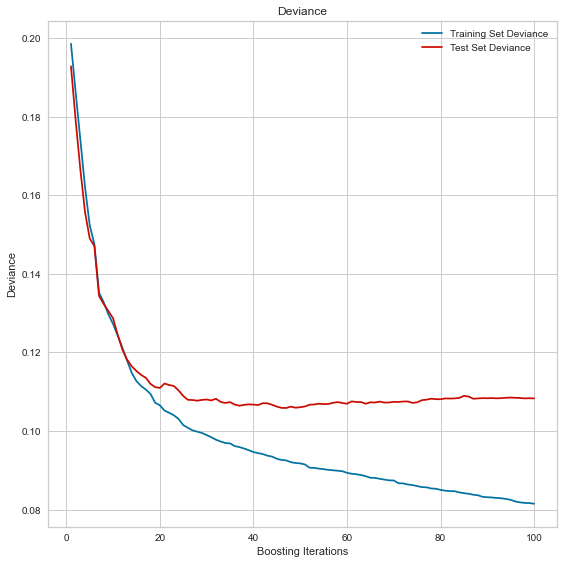

In [58]:
from matplotlib import pyplot as plt
# Assessing the training and test deviance (loss)
test_score = np.zeros((regressor_params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(regressor.staged_predict(X_test)):
    test_score[i] = regressor.loss_(y_test, y_pred)
 
fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(regressor_params['n_estimators']) + 1, regressor.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(regressor_params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()